## Import packages you need


In [1]:
# Import necessary packages.
import os
import copy
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, TensorDataset, Dataset
from torchvision.datasets import DatasetFolder

# If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


/home/alex/miniconda3/envs/4016/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Show current device name


In [2]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Dataset, Data Loader, and Transforms


In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.RandomResizedCrop((128, 128)),
    # transforms.RandomCrop(size=128, padding=10),

    # Randomly flip and rotate the image
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),

    # Randomly adjust the brightness and contrast of the image
    transforms.ColorJitter((0.875, 1.125), (0.5, 1.5), (0.5, 1.5), (-0.05, 0.05)),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),

    # Convert the image to a tensor
    transforms.RandAugment(),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 48

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../data/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../data/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../data/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("../data/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Model

model = torchvision.models.resnet18(pretrained=False) → This is fine.

model = torchvision.models.resnet18(pretrained=True) → This is NOT allowed.


## Training


In [4]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]


In [5]:
def get_pseudo_labels(dataset, model, threshold):
    # This functions generates pseudo-label of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    index = []
    label = []

    for i, batch in enumerate(tqdm(dataloader)):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # you may filter the data and construct a new dataset here.
        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                index.append(i * batch_size + j)
                label.append(int(torch.argmax(x)))

    # Turn off the eval mode.
    model.train()
    return PseudoDataset(Subset(dataset, index), label)


In [6]:
def model_snapshot(model, new_file=None, old_file=None):
    if os.path.exists(old_file) is True:
        os.remove(old_file)
    torch.save(model, new_file)


In [7]:
def train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, scheduler, train_loader, valid_loader, train_set, unlabeled_set):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []}
    curr_lr = optimizer.param_groups[0]['lr']
    best_acc = 0.
    best_loss = 100.
    best_epoch = 0
    best_model = None
    acc_threshold = 0.65
    pseudo_threshold = 0.95

    for epoch in range(n_epochs):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        if do_semi and best_acc > acc_threshold:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model, pseudo_threshold)

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}, lr = {curr_lr}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, lr = {curr_lr}")

        # Save the loss and accuracy for each epoch.
        history["train_loss"].append(train_loss)
        history["val_loss"].append(valid_loss)
        history["train_acc"].append(train_acc.cpu())
        history["val_acc"].append(valid_acc.cpu())
        history["lr"].append(curr_lr)

        # Update scheduler for learning rate.
        scheduler.step(valid_loss)

        # Dont ask, this is the only way to round the number for some reason
        if float(f"{valid_acc:.5f}") > float(f"{best_acc:.5f}") and round(valid_loss, 5) < round(best_loss, 5):
            model_snapshot(model.state_dict(), new_file=f"{epoch + 1}_{valid_acc}.pth", old_file=f"{best_epoch + 1}_{best_acc}.pth")
            best_acc = valid_acc
            best_loss = valid_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        if epoch - best_epoch >= 50:
            break

    # Return model and history for later use.
    return best_model, history


In [8]:
def concat_history(history1: dict, history2: dict):
    for key in history1.keys() & history2.keys():
        history1[key] = history1[key] + history2[key]


In [9]:
def plot_loss(history):
    plt.plot([*range(1, len(history["train_loss"]) + 1)], history["train_loss"])
    plt.plot([*range(1, len(history["val_loss"]) + 1)], history["val_loss"])
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend(labels=["Train", "Validation"])


In [10]:
def plot_acc(history):
    plt.plot([*range(1, len(history["train_acc"]) + 1)], history["train_acc"])
    plt.plot([*range(1, len(history["val_acc"]) + 1)], history["val_acc"])
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(labels=["Train", "Validation"])


In [11]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = torchvision.models.efficientnet_v2_l(weights=None).to(device)
# model_path = "model/name/path.pth"
# model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, threshold=1e-3)

# The number of training epochs.
n_epochs = 1000

# Whether to do semi-supervised learning.
# do_semi = False
do_semi = True

# Save history of accuracy and loss.
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []}


In [12]:
bestd_model, train_history = train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, scheduler, train_loader, valid_loader, train_set, unlabeled_set)
concat_history(history, train_history)


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 001/1000 ] loss = 5.19290, acc = 0.08772, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 001/1000 ] loss = 3.55200, acc = 0.10714, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 002/1000 ] loss = 2.57183, acc = 0.09095, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 002/1000 ] loss = 2.65298, acc = 0.07986, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 003/1000 ] loss = 2.48828, acc = 0.08631, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 003/1000 ] loss = 2.38942, acc = 0.09921, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 004/1000 ] loss = 2.45556, acc = 0.08873, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 004/1000 ] loss = 2.40552, acc = 0.10367, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 005/1000 ] loss = 2.42907, acc = 0.09690, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 005/1000 ] loss = 2.40137, acc = 0.08681, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 006/1000 ] loss = 2.41599, acc = 0.09655, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 006/1000 ] loss = 2.39818, acc = 0.10119, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 007/1000 ] loss = 2.42665, acc = 0.09277, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 007/1000 ] loss = 2.39297, acc = 0.09325, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 008/1000 ] loss = 2.42078, acc = 0.09035, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 008/1000 ] loss = 2.42113, acc = 0.10218, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 009/1000 ] loss = 2.41623, acc = 0.09120, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 009/1000 ] loss = 2.39422, acc = 0.11458, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 010/1000 ] loss = 2.40647, acc = 0.08964, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 010/1000 ] loss = 2.39487, acc = 0.11260, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 011/1000 ] loss = 2.40685, acc = 0.11194, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 011/1000 ] loss = 2.37479, acc = 0.13690, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 012/1000 ] loss = 2.40723, acc = 0.11002, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 012/1000 ] loss = 2.38650, acc = 0.11359, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 013/1000 ] loss = 2.40709, acc = 0.10402, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 013/1000 ] loss = 2.36729, acc = 0.12946, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 014/1000 ] loss = 2.40164, acc = 0.10598, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 014/1000 ] loss = 2.35659, acc = 0.13343, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 015/1000 ] loss = 2.39535, acc = 0.11108, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 015/1000 ] loss = 2.38417, acc = 0.12599, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 016/1000 ] loss = 2.39504, acc = 0.11062, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 016/1000 ] loss = 2.37006, acc = 0.14435, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 017/1000 ] loss = 2.39799, acc = 0.10800, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 017/1000 ] loss = 2.35151, acc = 0.11806, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 018/1000 ] loss = 2.39625, acc = 0.10689, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 018/1000 ] loss = 2.35904, acc = 0.14931, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 019/1000 ] loss = 2.40724, acc = 0.10048, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 019/1000 ] loss = 2.33394, acc = 0.15427, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 020/1000 ] loss = 2.40016, acc = 0.11426, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 020/1000 ] loss = 2.32075, acc = 0.15774, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 021/1000 ] loss = 2.38832, acc = 0.12253, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 021/1000 ] loss = 2.31536, acc = 0.15030, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 022/1000 ] loss = 2.38330, acc = 0.12611, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 022/1000 ] loss = 2.34043, acc = 0.14286, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 023/1000 ] loss = 2.38473, acc = 0.11955, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 023/1000 ] loss = 2.33462, acc = 0.15278, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 024/1000 ] loss = 2.37588, acc = 0.12127, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 024/1000 ] loss = 2.31523, acc = 0.14980, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 025/1000 ] loss = 2.37835, acc = 0.12450, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 025/1000 ] loss = 2.35499, acc = 0.14385, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 026/1000 ] loss = 2.37322, acc = 0.12727, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 026/1000 ] loss = 2.33585, acc = 0.13790, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 027/1000 ] loss = 2.36566, acc = 0.13716, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 027/1000 ] loss = 2.39994, acc = 0.11954, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 028/1000 ] loss = 2.35906, acc = 0.14013, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 028/1000 ] loss = 2.33135, acc = 0.14782, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 029/1000 ] loss = 2.35792, acc = 0.13095, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 029/1000 ] loss = 2.31263, acc = 0.15724, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 030/1000 ] loss = 2.34445, acc = 0.14800, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 030/1000 ] loss = 2.30619, acc = 0.15427, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 031/1000 ] loss = 2.34855, acc = 0.14150, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 031/1000 ] loss = 2.31755, acc = 0.13591, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 032/1000 ] loss = 2.34976, acc = 0.15163, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 032/1000 ] loss = 2.30328, acc = 0.14980, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 033/1000 ] loss = 2.35586, acc = 0.15143, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 033/1000 ] loss = 2.28426, acc = 0.18204, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 034/1000 ] loss = 2.34368, acc = 0.15738, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 034/1000 ] loss = 2.28481, acc = 0.17808, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 035/1000 ] loss = 2.35357, acc = 0.13605, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 035/1000 ] loss = 2.27023, acc = 0.16617, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 036/1000 ] loss = 2.33888, acc = 0.15163, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 036/1000 ] loss = 2.27871, acc = 0.17014, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 037/1000 ] loss = 2.33948, acc = 0.15118, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 037/1000 ] loss = 2.28788, acc = 0.18155, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 038/1000 ] loss = 2.33910, acc = 0.15733, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 038/1000 ] loss = 2.27318, acc = 0.18502, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 039/1000 ] loss = 2.34342, acc = 0.15708, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 039/1000 ] loss = 2.25109, acc = 0.18452, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 040/1000 ] loss = 2.33525, acc = 0.15648, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 040/1000 ] loss = 2.24720, acc = 0.20238, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 041/1000 ] loss = 2.32655, acc = 0.15597, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 041/1000 ] loss = 2.24687, acc = 0.19097, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 042/1000 ] loss = 2.32303, acc = 0.15890, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 042/1000 ] loss = 2.20819, acc = 0.19048, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 043/1000 ] loss = 2.32300, acc = 0.16162, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 043/1000 ] loss = 2.25632, acc = 0.18800, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 044/1000 ] loss = 2.31998, acc = 0.16566, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 044/1000 ] loss = 2.27535, acc = 0.15327, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 045/1000 ] loss = 2.32156, acc = 0.15668, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 045/1000 ] loss = 2.18523, acc = 0.22768, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 046/1000 ] loss = 2.32011, acc = 0.15744, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 046/1000 ] loss = 2.20915, acc = 0.23065, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 047/1000 ] loss = 2.30106, acc = 0.16586, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 047/1000 ] loss = 2.22620, acc = 0.21429, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 048/1000 ] loss = 2.30018, acc = 0.18276, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 048/1000 ] loss = 2.19592, acc = 0.22321, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 049/1000 ] loss = 2.31709, acc = 0.16425, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 049/1000 ] loss = 2.19172, acc = 0.21032, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 050/1000 ] loss = 2.30061, acc = 0.18054, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 050/1000 ] loss = 2.22000, acc = 0.19742, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 051/1000 ] loss = 2.30445, acc = 0.17035, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 051/1000 ] loss = 2.19176, acc = 0.22669, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 052/1000 ] loss = 2.29182, acc = 0.16949, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 052/1000 ] loss = 2.15684, acc = 0.23165, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 053/1000 ] loss = 2.28322, acc = 0.18609, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 053/1000 ] loss = 2.12798, acc = 0.26637, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 054/1000 ] loss = 2.27202, acc = 0.19381, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 054/1000 ] loss = 2.14222, acc = 0.23760, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 055/1000 ] loss = 2.29237, acc = 0.17282, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 055/1000 ] loss = 2.17369, acc = 0.24058, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 056/1000 ] loss = 2.27862, acc = 0.17903, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 056/1000 ] loss = 2.13607, acc = 0.25546, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 057/1000 ] loss = 2.27635, acc = 0.17459, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 057/1000 ] loss = 2.14130, acc = 0.23760, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 058/1000 ] loss = 2.26930, acc = 0.19446, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 058/1000 ] loss = 2.19823, acc = 0.21627, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 059/1000 ] loss = 2.26386, acc = 0.18740, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 059/1000 ] loss = 2.12204, acc = 0.26240, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 060/1000 ] loss = 2.26349, acc = 0.19789, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 060/1000 ] loss = 2.15204, acc = 0.24206, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 061/1000 ] loss = 2.25285, acc = 0.19996, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 061/1000 ] loss = 2.09214, acc = 0.26488, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 062/1000 ] loss = 2.25083, acc = 0.20021, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 062/1000 ] loss = 2.14920, acc = 0.24454, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 063/1000 ] loss = 2.25973, acc = 0.18821, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 063/1000 ] loss = 2.12014, acc = 0.26042, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 064/1000 ] loss = 2.24285, acc = 0.20808, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 064/1000 ] loss = 2.08719, acc = 0.27629, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 065/1000 ] loss = 2.24168, acc = 0.19784, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 065/1000 ] loss = 2.10048, acc = 0.23710, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 066/1000 ] loss = 2.24927, acc = 0.19804, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 066/1000 ] loss = 2.11967, acc = 0.23214, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 067/1000 ] loss = 2.23273, acc = 0.20384, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 067/1000 ] loss = 2.09382, acc = 0.25347, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 068/1000 ] loss = 2.24154, acc = 0.20092, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 068/1000 ] loss = 2.08075, acc = 0.28125, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 069/1000 ] loss = 2.24818, acc = 0.20551, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 069/1000 ] loss = 2.13494, acc = 0.25992, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 070/1000 ] loss = 2.23676, acc = 0.19275, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 070/1000 ] loss = 2.14997, acc = 0.22619, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 071/1000 ] loss = 2.21402, acc = 0.20606, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 071/1000 ] loss = 2.09843, acc = 0.26687, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 072/1000 ] loss = 2.24283, acc = 0.21691, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 072/1000 ] loss = 2.12296, acc = 0.24653, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 073/1000 ] loss = 2.21225, acc = 0.20707, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 073/1000 ] loss = 2.12000, acc = 0.24554, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 074/1000 ] loss = 2.22767, acc = 0.20869, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 074/1000 ] loss = 2.10302, acc = 0.23760, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 075/1000 ] loss = 2.22532, acc = 0.20505, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 075/1000 ] loss = 2.08976, acc = 0.26290, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 076/1000 ] loss = 2.22802, acc = 0.19976, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 076/1000 ] loss = 2.11337, acc = 0.24901, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 077/1000 ] loss = 2.22157, acc = 0.21555, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 077/1000 ] loss = 2.06029, acc = 0.26240, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 078/1000 ] loss = 2.20156, acc = 0.21444, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 078/1000 ] loss = 2.08055, acc = 0.27530, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 079/1000 ] loss = 2.21140, acc = 0.21131, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 079/1000 ] loss = 2.06227, acc = 0.27083, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 080/1000 ] loss = 2.20725, acc = 0.20763, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 080/1000 ] loss = 2.04786, acc = 0.29067, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 081/1000 ] loss = 2.20172, acc = 0.22437, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 081/1000 ] loss = 2.07268, acc = 0.26587, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 082/1000 ] loss = 2.22840, acc = 0.20268, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 082/1000 ] loss = 2.09655, acc = 0.26885, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 083/1000 ] loss = 2.20272, acc = 0.21731, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 083/1000 ] loss = 2.09259, acc = 0.26488, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 084/1000 ] loss = 2.19632, acc = 0.21731, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 084/1000 ] loss = 2.11170, acc = 0.27232, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 085/1000 ] loss = 2.17753, acc = 0.22321, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 085/1000 ] loss = 2.08564, acc = 0.26687, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 086/1000 ] loss = 2.18479, acc = 0.23456, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 086/1000 ] loss = 2.02534, acc = 0.29712, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 087/1000 ] loss = 2.16766, acc = 0.23083, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 087/1000 ] loss = 2.07672, acc = 0.27331, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 088/1000 ] loss = 2.19871, acc = 0.21398, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 088/1000 ] loss = 2.04631, acc = 0.26835, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 089/1000 ] loss = 2.20025, acc = 0.21403, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 089/1000 ] loss = 2.02450, acc = 0.28323, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 090/1000 ] loss = 2.16766, acc = 0.22786, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 090/1000 ] loss = 2.02640, acc = 0.29266, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 091/1000 ] loss = 2.17443, acc = 0.22316, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 091/1000 ] loss = 2.06335, acc = 0.27530, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 092/1000 ] loss = 2.17257, acc = 0.22654, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 092/1000 ] loss = 2.02328, acc = 0.27480, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 093/1000 ] loss = 2.17731, acc = 0.23149, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 093/1000 ] loss = 2.04371, acc = 0.27183, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 094/1000 ] loss = 2.16896, acc = 0.22402, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 094/1000 ] loss = 2.05796, acc = 0.28274, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 095/1000 ] loss = 2.16814, acc = 0.22649, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 095/1000 ] loss = 2.01233, acc = 0.31448, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 096/1000 ] loss = 2.18018, acc = 0.23290, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 096/1000 ] loss = 2.01008, acc = 0.31746, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 097/1000 ] loss = 2.16854, acc = 0.22458, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 097/1000 ] loss = 2.01901, acc = 0.28869, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 098/1000 ] loss = 2.18207, acc = 0.22922, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 098/1000 ] loss = 1.98065, acc = 0.31746, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 099/1000 ] loss = 2.16859, acc = 0.22412, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 099/1000 ] loss = 2.03682, acc = 0.29315, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 100/1000 ] loss = 2.14636, acc = 0.24506, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 100/1000 ] loss = 2.01184, acc = 0.29613, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 101/1000 ] loss = 2.17312, acc = 0.22291, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 101/1000 ] loss = 2.01126, acc = 0.29415, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 102/1000 ] loss = 2.15392, acc = 0.23441, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 102/1000 ] loss = 2.01023, acc = 0.30407, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 103/1000 ] loss = 2.16473, acc = 0.22775, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 103/1000 ] loss = 2.02245, acc = 0.28968, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 104/1000 ] loss = 2.15515, acc = 0.22937, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 104/1000 ] loss = 2.05768, acc = 0.28671, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 105/1000 ] loss = 2.13593, acc = 0.22553, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 105/1000 ] loss = 1.96482, acc = 0.31796, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 106/1000 ] loss = 2.14846, acc = 0.23749, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 106/1000 ] loss = 1.98496, acc = 0.30357, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 107/1000 ] loss = 2.12749, acc = 0.24102, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 107/1000 ] loss = 1.99455, acc = 0.29712, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 108/1000 ] loss = 2.13248, acc = 0.25288, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 108/1000 ] loss = 1.97191, acc = 0.32093, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 109/1000 ] loss = 2.13425, acc = 0.24077, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 109/1000 ] loss = 1.99053, acc = 0.29415, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 110/1000 ] loss = 2.14640, acc = 0.23900, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 110/1000 ] loss = 1.99338, acc = 0.29415, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 111/1000 ] loss = 2.11407, acc = 0.24667, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 111/1000 ] loss = 1.98202, acc = 0.30010, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 112/1000 ] loss = 2.13579, acc = 0.25747, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 112/1000 ] loss = 2.00488, acc = 0.28522, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 113/1000 ] loss = 2.13391, acc = 0.25288, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 113/1000 ] loss = 1.98087, acc = 0.31548, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 114/1000 ] loss = 2.12103, acc = 0.24511, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 114/1000 ] loss = 1.96258, acc = 0.31696, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 115/1000 ] loss = 2.11735, acc = 0.25671, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 115/1000 ] loss = 1.98103, acc = 0.31349, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 116/1000 ] loss = 2.11675, acc = 0.24798, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 116/1000 ] loss = 1.97388, acc = 0.32093, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 117/1000 ] loss = 2.12354, acc = 0.25091, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 117/1000 ] loss = 1.95503, acc = 0.32490, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 118/1000 ] loss = 2.10260, acc = 0.25686, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 118/1000 ] loss = 1.95131, acc = 0.32788, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 119/1000 ] loss = 2.12476, acc = 0.25328, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 119/1000 ] loss = 1.96796, acc = 0.32242, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 120/1000 ] loss = 2.09851, acc = 0.26271, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 120/1000 ] loss = 1.95578, acc = 0.30754, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 121/1000 ] loss = 2.12354, acc = 0.24450, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 121/1000 ] loss = 1.95277, acc = 0.32093, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 122/1000 ] loss = 2.10198, acc = 0.24475, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 122/1000 ] loss = 2.00138, acc = 0.30010, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 123/1000 ] loss = 2.12687, acc = 0.25686, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 123/1000 ] loss = 1.95659, acc = 0.32440, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 124/1000 ] loss = 2.11556, acc = 0.25646, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 124/1000 ] loss = 1.94380, acc = 0.33829, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 125/1000 ] loss = 2.09704, acc = 0.25454, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 125/1000 ] loss = 1.94627, acc = 0.32391, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 126/1000 ] loss = 2.10570, acc = 0.25686, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 126/1000 ] loss = 1.96057, acc = 0.30804, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 127/1000 ] loss = 2.09759, acc = 0.26720, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 127/1000 ] loss = 1.95535, acc = 0.31151, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 128/1000 ] loss = 2.12791, acc = 0.24309, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 128/1000 ] loss = 1.96365, acc = 0.31300, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 129/1000 ] loss = 2.10140, acc = 0.26574, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 129/1000 ] loss = 1.95290, acc = 0.32589, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 130/1000 ] loss = 2.10262, acc = 0.24904, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 130/1000 ] loss = 1.96114, acc = 0.31052, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 131/1000 ] loss = 2.12921, acc = 0.25676, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 131/1000 ] loss = 1.95053, acc = 0.32093, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 132/1000 ] loss = 2.11886, acc = 0.24899, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 132/1000 ] loss = 1.94657, acc = 0.32937, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 133/1000 ] loss = 2.12713, acc = 0.24834, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 133/1000 ] loss = 1.96992, acc = 0.31300, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 134/1000 ] loss = 2.08508, acc = 0.26175, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 134/1000 ] loss = 1.95273, acc = 0.31845, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 135/1000 ] loss = 2.08261, acc = 0.26433, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 135/1000 ] loss = 1.97033, acc = 0.31052, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 136/1000 ] loss = 2.09813, acc = 0.25535, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 136/1000 ] loss = 1.95937, acc = 0.30357, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 137/1000 ] loss = 2.09672, acc = 0.26544, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 137/1000 ] loss = 1.94625, acc = 0.31796, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 138/1000 ] loss = 2.10415, acc = 0.26438, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 138/1000 ] loss = 1.95530, acc = 0.31349, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 139/1000 ] loss = 2.10829, acc = 0.26342, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 139/1000 ] loss = 1.95883, acc = 0.32639, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 140/1000 ] loss = 2.10158, acc = 0.25525, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 140/1000 ] loss = 1.94606, acc = 0.32589, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 141/1000 ] loss = 2.10419, acc = 0.25858, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 141/1000 ] loss = 1.94966, acc = 0.32143, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 142/1000 ] loss = 2.08753, acc = 0.25499, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 142/1000 ] loss = 1.94210, acc = 0.31746, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 143/1000 ] loss = 2.11040, acc = 0.26110, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 143/1000 ] loss = 1.95180, acc = 0.31944, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 144/1000 ] loss = 2.09789, acc = 0.25590, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 144/1000 ] loss = 1.93114, acc = 0.33185, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 145/1000 ] loss = 2.11528, acc = 0.24697, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 145/1000 ] loss = 1.96158, acc = 0.31498, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 146/1000 ] loss = 2.08665, acc = 0.26448, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 146/1000 ] loss = 1.94560, acc = 0.32044, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 147/1000 ] loss = 2.08738, acc = 0.26806, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 147/1000 ] loss = 1.94180, acc = 0.32192, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 148/1000 ] loss = 2.09358, acc = 0.25449, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 148/1000 ] loss = 1.94623, acc = 0.31746, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 149/1000 ] loss = 2.10619, acc = 0.26301, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 149/1000 ] loss = 1.95071, acc = 0.31845, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 150/1000 ] loss = 2.09623, acc = 0.26387, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 150/1000 ] loss = 1.94331, acc = 0.32143, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 151/1000 ] loss = 2.08344, acc = 0.26382, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 151/1000 ] loss = 1.95257, acc = 0.32192, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 152/1000 ] loss = 2.11083, acc = 0.25494, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 152/1000 ] loss = 1.94449, acc = 0.31597, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 153/1000 ] loss = 2.08344, acc = 0.25928, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 153/1000 ] loss = 1.95433, acc = 0.32044, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 154/1000 ] loss = 2.08500, acc = 0.26609, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 154/1000 ] loss = 1.94475, acc = 0.31895, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 155/1000 ] loss = 2.09581, acc = 0.26670, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 155/1000 ] loss = 1.95520, acc = 0.30308, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 156/1000 ] loss = 2.07922, acc = 0.26372, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 156/1000 ] loss = 1.93531, acc = 0.31994, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 157/1000 ] loss = 2.08922, acc = 0.26544, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 157/1000 ] loss = 1.95191, acc = 0.31399, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 158/1000 ] loss = 2.08838, acc = 0.25575, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 158/1000 ] loss = 1.94526, acc = 0.32292, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 159/1000 ] loss = 2.11132, acc = 0.24697, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 159/1000 ] loss = 1.94570, acc = 0.31944, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 160/1000 ] loss = 2.09630, acc = 0.26190, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 160/1000 ] loss = 1.94559, acc = 0.30754, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 161/1000 ] loss = 2.09969, acc = 0.26120, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 161/1000 ] loss = 1.93587, acc = 0.32639, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 162/1000 ] loss = 2.11015, acc = 0.24364, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 162/1000 ] loss = 1.94720, acc = 0.31597, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 163/1000 ] loss = 2.09995, acc = 0.25873, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 163/1000 ] loss = 1.94621, acc = 0.31597, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 164/1000 ] loss = 2.08756, acc = 0.25227, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 164/1000 ] loss = 1.95439, acc = 0.32143, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 165/1000 ] loss = 2.10108, acc = 0.25141, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 165/1000 ] loss = 1.93325, acc = 0.33333, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 166/1000 ] loss = 2.09390, acc = 0.25686, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 166/1000 ] loss = 1.94574, acc = 0.32143, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 167/1000 ] loss = 2.09384, acc = 0.25837, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 167/1000 ] loss = 1.92716, acc = 0.33581, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 168/1000 ] loss = 2.09464, acc = 0.25454, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 168/1000 ] loss = 1.95149, acc = 0.31746, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 169/1000 ] loss = 2.11394, acc = 0.25242, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 169/1000 ] loss = 1.95304, acc = 0.31448, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 170/1000 ] loss = 2.08284, acc = 0.27068, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 170/1000 ] loss = 1.93591, acc = 0.32589, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 171/1000 ] loss = 2.12117, acc = 0.24612, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 171/1000 ] loss = 1.93796, acc = 0.32986, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 172/1000 ] loss = 2.11539, acc = 0.25414, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 172/1000 ] loss = 1.95392, acc = 0.30704, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 173/1000 ] loss = 2.11111, acc = 0.25197, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 173/1000 ] loss = 1.94361, acc = 0.31746, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 174/1000 ] loss = 2.10510, acc = 0.25918, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 174/1000 ] loss = 1.94495, acc = 0.31399, lr = 0.0003


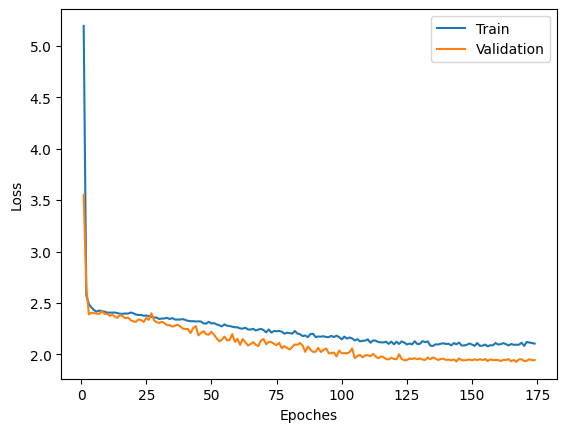

In [13]:
plot_loss(history)


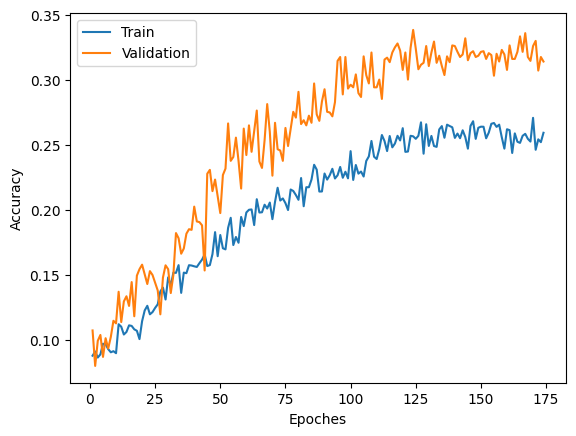

In [14]:
plot_acc(history)


## Testing


In [15]:
# model_path = "model/modelName/savedName.pth"
# bestd_model.load_state_dict(torch.load(model_path, map_location=device))


In [16]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
bestd_model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = bestd_model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


  0%|          | 0/67 [00:00<?, ?it/s]

In [17]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
